In [1]:
import os
os.chdir('..')

from style_transfer import *
from IPython.display import Audio
from dataset import ItemClass
import torch
from model import *
import natsort
import glob

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/envs/proj/envs/waveglow/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = {
    'n_mels': 80, 
    'n_fft': 1024,
    'fmin': 0,
    'fmax': 8000,
    'sr': 22050,
    'win_length': 1024,
    'hop_length': 256,
    'wav_max_length': 3024,
    'transcript_max_length': 580,
    'learning_rate': 1e-5, #1e-3, 
    'batch_size': 1, #12
    'weight_decay': 0, 
    'encoder_num_layers': 2,
    'encoder_hidden_dim': 256//2,
    'encoder_bidirectional': True,
    'encoder_dropout': 0.2,
    'decoder_hidden_dim': 512//2,  # must be 2 x encoder_hidden_dim
    'decoder_num_layers': 2,
    'decoder_multi_head': 1,
    'decoder_mlp_dim': 64,
    'asr_label_smooth': 0.1,
    'teacher_force_prob': 0.9,
    'ctc_weight': 0.5,
    'asr_weight': 0.7,
    'speaker_id_weight': 0.3
}

In [3]:
model_path = natsort.natsorted(glob.glob('asr/trained_models/wavglow-styletransfer/*'))[-1]
print(f"Loading model: {model_path}")
d = torch.load(model_path)

asr = LightningCTCLASMTL(**config)
asr.load_state_dict(d['state_dict'])
asr.to(device)

IndexError: list index out of range

In [9]:
alice_hf_sample = asr.train_dataset.hf_ds[5230]
alice_sample = asr.train_dataset[5230]
alice_audio = alice_hf_sample['audio']
Audio(data=alice_audio['array'], rate=alice_audio['sampling_rate'])

/opt/conda/envs/proj/envs/waveglow/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


In [5]:
bob_hf_sample = asr.train_dataset.hf_ds[10746]
bob_audio = bob_hf_sample['audio']
Audio(data=bob_audio['array'], rate=bob_audio['sampling_rate'])

In [19]:
def dummy_batch(x):
    return ItemClass(
        x.input_feature.unsqueeze(0),
        torch.Tensor([x.input_mean]),
        torch.Tensor([x.input_std]),
        torch.Tensor([x.input_length]),
        x.input_path,
        x.human_transcript_label.unsqueeze(0),
        torch.Tensor([x.human_transcript_length]),
        torch.Tensor([x.speaker_idx])
    ).my_to(device)

In [11]:
# alice_id = alice_hf_sample['speaker_id']
# bob_id = bob_hf_sample['speaker_id']

# cache = SampleCache(asr, alice_id, bob_id, 10, 259, device)
sample_cache = torch.load('sample_cache.pt')

In [20]:
st = StyleTransfer(asr, dummy_batch(alice_sample), sample_cache, contrastive_style_loss, 100)

AttributeError: 'ItemClass' object has no attribute 'my_to'

In [13]:
results = st.analyze()

ValueError: not enough values to unpack (expected 3, got 2)

In [14]:
import shelve
with shelve.open(STYLE_TRANSFER_ARCHIVE) as db:
    results = db[alice_sample.input_path + ':' + bob_sample.input_path]
    results['content_norm'] = alice_sample.input_norm

# db = dir_archive(STYLE_TRANSFER_ARCHIVE, serialized=True, cached=False)
# results = db[(alice_sample.input_path, bob_sample.input_path)]

In [9]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_log_spectrogram(mel):
  fig, ax = plt.subplots(1,1,figsize=(20,5))
#   sr, wavdata = wavfile.read(test_manifest[key]['wav'])
  sr = 22050
#   wavdata = 
#   mel = librosa.feature.melspectrogram(wavdata, sr, n_fft=2048, fmin=0, fmax=sr/2, n_mels=256)
#   mel_db = librosa.power_to_db(mel, ref=np.max)
  img = librosa.display.specshow(mel, y_axis='mel', x_axis='time', fmax=sr/2, ax=ax)
  ax.set(title='Mel spectrogram display')
  fig.colorbar(img, ax=ax, format="%+2.f dB")

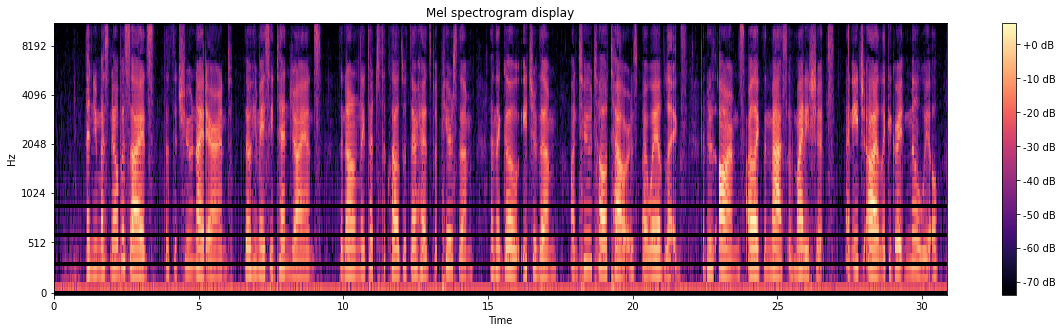

In [10]:
plot_log_spectrogram((results['content_mels'].detach().cpu() * alice_sample.input_norm.cpu()).cpu().T.numpy())

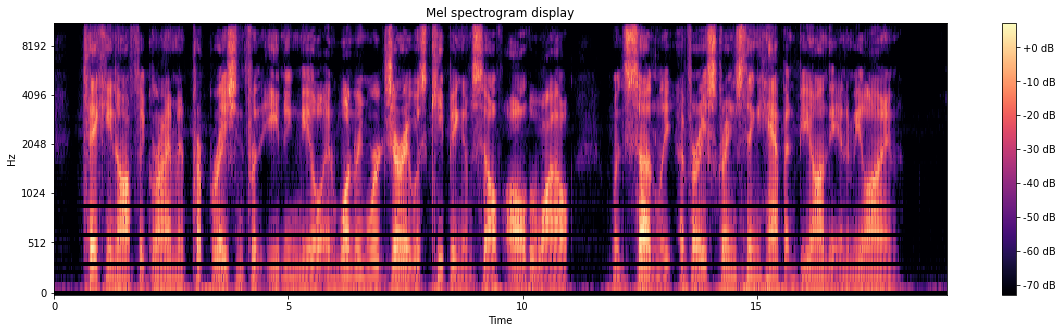

In [11]:
plot_log_spectrogram((results['style_mels'].detach().cpu() * bob_sample.input_norm.cpu()).cpu().T.numpy())

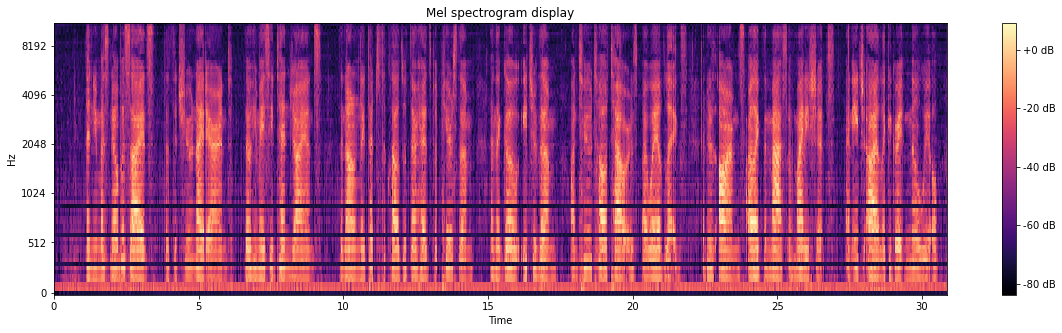

In [12]:
plot_log_spectrogram((results['posttransfer_mels'].detach().cpu() * alice_sample.input_norm.cpu()).cpu().T.numpy())

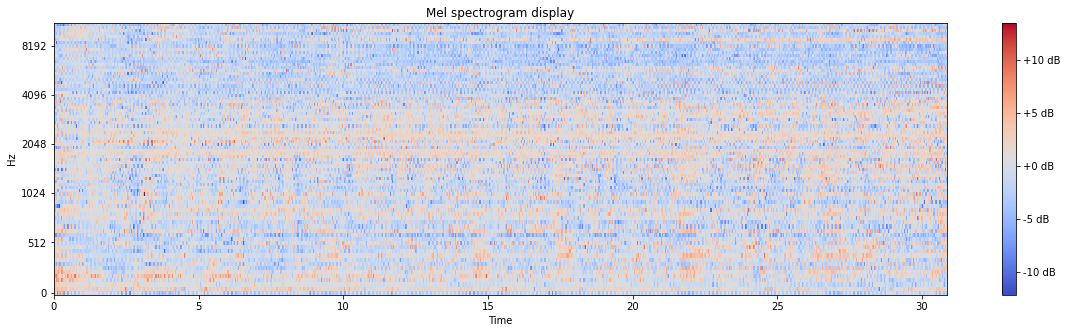

In [13]:
plot_log_spectrogram(((results['content_mels'] - results['posttransfer_mels']).cpu() * alice_sample.input_norm.cpu()).detach().cpu().T.numpy())

In [14]:
from types import SimpleNamespace
cfg = SimpleNamespace(**config)

In [22]:
spectrogram = (results['posttransfer_mels'].detach().cpu() * results['content_norm'][0, ...].cpu()).cpu().T.numpy() # posttransfer_mels
power = librosa.db_to_power(spectrogram)
posttransfer_audio = librosa.feature.inverse.mel_to_audio(power, sr=cfg.sr, 
            n_fft=cfg.n_fft,
            win_length=cfg.win_length, hop_length=cfg.hop_length,
            fmin=cfg.fmin, fmax=cfg.fmax)

In [23]:
Audio(data=posttransfer_audio, rate=cfg.sr)

# Vocoder

In [28]:
# rescaled_mels = (results['posttransfer_mels'].detach() * alice_sample.input_norm).cpu().T
# rescaled_mels = (results['content_mels'].detach().cpu() * alice_sample.input_norm.cpu()).cpu().T.numpy()
# rescaled_mels = librosa.db_to_power(rescaled_mels)
rescaled_mels = torch.Tensor(power)
torch.save(rescaled_mels, 'style_transfers/' + alice_sample.input_path + ':' + bob_sample.input_path + '.pt')

In [25]:
!mkdir -p style_transfers

In [26]:
%%writefile style_transfers/mel_files.txt
../style_transfers/2989-138028-0010.flac:4014-186183-0019.flac.pt

Writing style_transfers/mel_files.txt


In [30]:
%cd waveglow
!python3 inference.py -f ../style_transfers/mel_files.txt -w waveglow_256channels.pt -o ../style_transfers --is_fp16 -s 0.6
%cd ..

/home/ani.vegesana.backup/cs224s-project/waveglow
/opt/conda/envs/proj/envs/waveglow/lib/python3.9/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/envs/proj/envs/waveglow/lib/python3.9/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/envs/proj/envs/waveglow/lib/python3.9/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn